# Definitive Statistical Evaluation of SG-FIGS Hypothesis

This notebook performs a comprehensive statistical evaluation of the **Synergy-Guided FIGS (SG-FIGS)** method against baselines across multiple datasets.

**What it does:**
- Runs Friedman tests and Nemenyi post-hoc analysis on 5 methods (FIGS, RO-FIGS, SG-FIGS-Hard, SG-FIGS-Soft, Random-FIGS)
- Performs pairwise Wilcoxon signed-rank tests with Holm-Bonferroni correction
- Evaluates 3 success criteria: accuracy-complexity tradeoff, interpretability, and domain validation
- Conducts ablation analysis (synergy-guided vs random pair selection)
- Analyzes threshold sensitivity and Pareto optimality

In [ ]:
%%capture
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# Core packages (pre-installed on Colab, only needed locally)
if 'google.colab' not in sys.modules:
    _pip('scipy==1.16.3', 'matplotlib==3.10.0')

In [2]:
import json
import sys
from itertools import combinations
from collections import defaultdict

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-fb8249-synergy-guided-oblique-splits-using-part/main/evaluation_iter4_sg_figs_eval/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded evaluation data: {data['metadata']['evaluation_name']}")
print(f"Datasets: {len(data['datasets'])}")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded evaluation data: SG-FIGS Definitive Statistical Evaluation
Datasets: 10
  accuracy_comparison: 3 examples
  statistical_tests: 3 examples
  ablation_analysis: 3 examples
  criterion_1_accuracy_complexity: 3 examples
  criterion_2_interpretability: 3 examples
  criterion_3_domain_validation: 3 examples
  threshold_sensitivity: 3 examples
  pareto_analysis: 3 examples
  dataset_regression: 3 examples
  overall_verdict: 1 examples


## Configuration

Define all tunable parameters for the statistical evaluation.

In [5]:
# ── Configuration ────────────────────────────────────────────────────────────
# Statistical test parameters
ALPHA = 0.05                # Significance level for all tests
SYNERGY_PERCENTILE = 75     # Percentile threshold for synergy graph construction
TOP_K_SYNERGY = 3           # Number of top synergy pairs for domain validation
TOP_K_MI = 5                # Number of top MI features for Jaccard overlap
WLT_TOLERANCE = 1e-6        # Tolerance for win/loss/tie comparisons

# Criterion 1 thresholds
C1_ACC_TOLERANCE = 0.01     # Accuracy tolerance for "competitive" performance
C1_SPLIT_RATIO_THRESH = 0.80  # Max split ratio for complexity reduction

# Method definitions
METHODS = ["figs", "ro_figs", "sg_figs_hard", "sg_figs_soft", "random_figs"]
METHOD_LABELS = {
    "figs": "FIGS",
    "ro_figs": "RO-FIGS",
    "sg_figs_hard": "SG-FIGS-Hard",
    "sg_figs_soft": "SG-FIGS-Soft",
    "random_figs": "Random-FIGS",
}

# Domain knowledge for Criterion 3 validation
DOMAIN_INTERACTIONS = {
    "pima_diabetes": [
        ({"plas", "mass"}, "glucose-BMI interaction"),
        ({"plas", "age"}, "glucose-age interaction"),
        ({"mass", "skin"}, "BMI-skin thickness interaction"),
        ({"plas", "insu"}, "glucose-insulin interaction"),
    ],
    "breast_cancer": [
        ({"mean concave points", "mean radius"}, "concave_points-radius"),
        ({"mean concave points", "worst radius"}, "concave_points-worst_radius"),
        ({"mean concavity", "mean perimeter"}, "concavity-perimeter"),
        ({"worst concave points", "worst perimeter"}, "worst_concave_points-perimeter"),
    ],
    "heart_statlog": [
        ({"chest", "thal"}, "chest_pain-thal interaction"),
        ({"age", "maximum_heart_rate_achieved"}, "age-max HR interaction"),
        ({"oldpeak", "slope"}, "ST depression-slope interaction"),
    ],
    "monks2": [
        ({"a1", "a2"}, "XOR features a1-a2"),
        ({"a4", "a5"}, "XOR features a4-a5"),
    ],
}

print("Configuration loaded.")

Configuration loaded.


## Helper Functions

Statistical testing functions: Friedman test, Nemenyi critical difference, pairwise Wilcoxon with Holm-Bonferroni correction, and utility functions.

In [6]:
def friedman_test(accuracy_matrix: np.ndarray) -> tuple:
    """Perform Friedman test on N×k matrix (N datasets, k methods).

    Returns (chi2, p_value, ranks_per_method, full_ranks_matrix).
    """
    n, k = accuracy_matrix.shape
    # Rank within each row (dataset) — higher accuracy → lower rank (rank 1 = best)
    ranks = np.zeros_like(accuracy_matrix)
    for i in range(n):
        ranks[i] = stats.rankdata(-accuracy_matrix[i])

    avg_ranks = ranks.mean(axis=0)

    # Friedman statistic
    chi2 = (12 * n) / (k * (k + 1)) * (np.sum(avg_ranks**2) - k * ((k + 1) ** 2) / 4)
    p_value = 1 - stats.chi2.cdf(chi2, df=k - 1)

    return float(chi2), float(p_value), avg_ranks.tolist(), ranks


def nemenyi_cd(k: int, n: int, alpha: float = 0.05) -> float:
    """Compute Nemenyi critical difference.

    CD = q_alpha * sqrt(k*(k+1)/(6*N))
    """
    q_table = {2: 1.960, 3: 2.343, 4: 2.569, 5: 2.728, 6: 2.850, 7: 2.949, 8: 3.031, 9: 3.102, 10: 3.164}
    q = q_table.get(k, 2.728)
    cd = q * np.sqrt(k * (k + 1) / (6 * n))
    return float(cd)


def pairwise_wilcoxon_holm(
    accuracy_matrix: np.ndarray,
    method_names: list,
) -> list:
    """Pairwise Wilcoxon signed-rank tests with Holm-Bonferroni correction."""
    k = len(method_names)
    pairs = list(combinations(range(k), 2))
    raw_results = []

    for i, j in pairs:
        diffs = accuracy_matrix[:, i] - accuracy_matrix[:, j]
        nonzero = diffs[diffs != 0]
        if len(nonzero) < 2:
            raw_results.append({
                "pair": f"{method_names[i]} vs {method_names[j]}",
                "statistic": None, "p_raw": 1.0,
                "mean_diff": float(np.mean(diffs)),
            })
            continue
        try:
            stat, p = stats.wilcoxon(nonzero, alternative="two-sided")
            raw_results.append({
                "pair": f"{method_names[i]} vs {method_names[j]}",
                "statistic": float(stat), "p_raw": float(p),
                "mean_diff": float(np.mean(diffs)),
            })
        except ValueError:
            raw_results.append({
                "pair": f"{method_names[i]} vs {method_names[j]}",
                "statistic": None, "p_raw": 1.0,
                "mean_diff": float(np.mean(diffs)),
            })

    # Holm-Bonferroni correction
    sorted_idx = sorted(range(len(raw_results)), key=lambda x: raw_results[x]["p_raw"])
    m = len(raw_results)
    for rank_pos, idx in enumerate(sorted_idx):
        p_adj = raw_results[idx]["p_raw"] * (m - rank_pos)
        raw_results[idx]["p_corrected"] = min(float(p_adj), 1.0)
        raw_results[idx]["significant"] = raw_results[idx]["p_corrected"] < ALPHA

    return raw_results


def win_loss_tie(vals_a: np.ndarray, vals_b: np.ndarray, tol: float = None) -> dict:
    """Count wins, losses, ties between two arrays."""
    if tol is None:
        tol = WLT_TOLERANCE
    diffs = vals_a - vals_b
    return {
        "wins": int(np.sum(diffs > tol)),
        "losses": int(np.sum(diffs < -tol)),
        "ties": int(np.sum(np.abs(diffs) <= tol)),
    }


def linear_regression_r2(x: np.ndarray, y: np.ndarray) -> tuple:
    """Simple linear regression returning slope, intercept, R², p_value."""
    if len(x) < 3 or np.std(x) < 1e-10 or np.std(y) < 1e-10:
        return 0.0, 0.0, 0.0, 1.0
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return float(slope), float(intercept), float(r_value**2), float(p_value)


print("Helper functions defined.")

Helper functions defined.


## Step 1: Extract Accuracy Comparison Data

Build the accuracy matrix from the per-dataset accuracy comparison examples. Each row is a dataset, each column is a method.

In [7]:
# Find accuracy_comparison dataset in loaded data
acc_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "accuracy_comparison")
dataset_names = [ex["metadata_dataset"] for ex in acc_ds["examples"]]
n_datasets = len(dataset_names)

# Build accuracy matrix: N datasets × k methods
acc_matrix = np.zeros((n_datasets, len(METHODS)))
interp_matrix = {}  # {dataset: {method: interpretability}}
splits_matrix = {}  # {dataset: {method: n_splits}}

for i, ex in enumerate(acc_ds["examples"]):
    output = json.loads(ex["output"])
    interp_matrix[dataset_names[i]] = {}
    splits_matrix[dataset_names[i]] = {}
    for j, m in enumerate(METHODS):
        acc_matrix[i, j] = output[f"{m}_acc_mean"]
        interp_matrix[dataset_names[i]][m] = output.get(f"{m}_interpretability")
        splits_matrix[dataset_names[i]][m] = output.get(f"{m}_n_splits")

print(f"Accuracy matrix shape: {acc_matrix.shape} ({n_datasets} datasets × {len(METHODS)} methods)")
print(f"\nPer-method mean balanced accuracy:")
for j, m in enumerate(METHODS):
    print(f"  {METHOD_LABELS[m]:>15}: {acc_matrix[:, j].mean():.4f}")

Accuracy matrix shape: (3, 5) (3 datasets × 5 methods)

Per-method mean balanced accuracy:
             FIGS: 0.8505
          RO-FIGS: 0.8526
     SG-FIGS-Hard: 0.8641
     SG-FIGS-Soft: 0.8636
      Random-FIGS: 0.8486


## Step 2: Friedman Test & Nemenyi Post-Hoc

Non-parametric test for differences among k related groups (methods) across N datasets. The Nemenyi critical difference determines which pairwise rank differences are significant.

In [8]:
# Friedman test on balanced accuracy
chi2_acc, p_acc, avg_ranks_acc, ranks_acc = friedman_test(acc_matrix)
cd = nemenyi_cd(k=len(METHODS), n=n_datasets, alpha=ALPHA)

print(f"Friedman Test on Balanced Accuracy:")
print(f"  χ² = {chi2_acc:.4f}, p = {p_acc:.6f} {'(SIGNIFICANT)' if p_acc < ALPHA else '(not significant)'}")
print(f"  Nemenyi CD (α={ALPHA}) = {cd:.4f}")
print(f"\nAverage ranks (1 = best):")
for j, m in enumerate(METHODS):
    print(f"  {METHOD_LABELS[m]:>15}: avg rank = {avg_ranks_acc[j]:.3f}")

Friedman Test on Balanced Accuracy:
  χ² = 7.2000, p = 0.125689 (not significant)
  Nemenyi CD (α=0.05) = 3.5218

Average ranks (1 = best):
             FIGS: avg rank = 4.000
          RO-FIGS: avg rank = 3.667
     SG-FIGS-Hard: avg rank = 1.667
     SG-FIGS-Soft: avg rank = 1.667
      Random-FIGS: avg rank = 4.000


## Step 3: Pairwise Wilcoxon Tests with Holm-Bonferroni Correction

All 10 pairwise comparisons between the 5 methods, with family-wise error rate control.

In [9]:
method_labels_list = [METHOD_LABELS[m] for m in METHODS]
wilcoxon_results = pairwise_wilcoxon_holm(acc_matrix, method_labels_list)

print(f"Pairwise Wilcoxon Signed-Rank Tests (Holm-Bonferroni corrected):")
print(f"{'Pair':>42}  {'p_raw':>8}  {'p_adj':>8}  {'Δmean':>8}  {'Sig':>3}")
print("-" * 80)
for r in wilcoxon_results:
    sig_str = "***" if r["significant"] else ""
    print(f"  {r['pair']:>40}: {r['p_raw']:8.4f}  {r['p_corrected']:8.4f}  {r['mean_diff']:+8.4f}  {sig_str}")

Pairwise Wilcoxon Signed-Rank Tests (Holm-Bonferroni corrected):
                                      Pair     p_raw     p_adj     Δmean  Sig
--------------------------------------------------------------------------------
                           FIGS vs RO-FIGS:   0.7500    1.0000   -0.0022  
                      FIGS vs SG-FIGS-Hard:   0.2500    1.0000   -0.0136  
                      FIGS vs SG-FIGS-Soft:   0.5000    1.0000   -0.0131  
                       FIGS vs Random-FIGS:   1.0000    1.0000   +0.0019  
                   RO-FIGS vs SG-FIGS-Hard:   0.2500    1.0000   -0.0114  
                   RO-FIGS vs SG-FIGS-Soft:   0.2500    1.0000   -0.0110  
                    RO-FIGS vs Random-FIGS:   0.5000    1.0000   +0.0040  
              SG-FIGS-Hard vs SG-FIGS-Soft:   1.0000    1.0000   +0.0004  
               SG-FIGS-Hard vs Random-FIGS:   0.2500    1.0000   +0.0155  
               SG-FIGS-Soft vs Random-FIGS:   0.2500    1.0000   +0.0150  


## Step 4: Ablation Analysis — SG-FIGS vs Random-FIGS

Tests whether synergy-guided pair selection provides a real advantage over random pair selection, in both accuracy and interpretability.

In [10]:
# Get ablation data from the ablation_analysis dataset
abl_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "ablation_analysis")

hard_accs, random_accs, hard_interps, random_interps = [], [], [], []
abl_datasets = []
for ex in abl_ds["examples"]:
    output = json.loads(ex["output"])
    abl_datasets.append(ex["metadata_dataset"])
    hard_accs.append(output["hard_acc"])
    random_accs.append(output["random_acc"])
    if output.get("hard_interpretability") is not None and output.get("random_interpretability") is not None:
        hard_interps.append(output["hard_interpretability"])
        random_interps.append(output["random_interpretability"])

hard_acc = np.array(hard_accs)
random_acc = np.array(random_accs)
delta_hard_random = hard_acc - random_acc
wlt_hard = win_loss_tie(hard_acc, random_acc)

# Wilcoxon test for accuracy
nonzero_hr = delta_hard_random[delta_hard_random != 0]
if len(nonzero_hr) >= 2:
    try:
        stat_hr, p_hr = stats.wilcoxon(nonzero_hr)
    except ValueError:
        stat_hr, p_hr = None, 1.0
else:
    stat_hr, p_hr = None, 1.0

print("Ablation: SG-FIGS-Hard vs Random-FIGS")
print(f"  Mean Δacc = {np.mean(delta_hard_random):+.4f}")
print(f"  W/L/T = {wlt_hard}")
print(f"  Wilcoxon p = {p_hr:.4f}")

# Interpretability ablation
if len(hard_interps) >= 2:
    interp_hard_arr = np.array(hard_interps)
    interp_random_arr = np.array(random_interps)
    delta_interp = interp_hard_arr - interp_random_arr
    nonzero_interp = delta_interp[delta_interp != 0]
    if len(nonzero_interp) >= 2:
        try:
            _, p_interp = stats.wilcoxon(nonzero_interp)
        except ValueError:
            p_interp = 1.0
    else:
        p_interp = 1.0
    print(f"\n  Interpretability ablation:")
    print(f"    Mean Δinterp = {np.mean(delta_interp):+.4f}")
    print(f"    Wilcoxon p = {p_interp:.4f}")
else:
    p_interp = 1.0
    delta_interp = np.array([0.0])

Ablation: SG-FIGS-Hard vs Random-FIGS
  Mean Δacc = +0.0155
  W/L/T = {'wins': 3, 'losses': 0, 'ties': 0}
  Wilcoxon p = 0.2500

  Interpretability ablation:
    Mean Δinterp = +0.3711
    Wilcoxon p = 0.2500


## Step 5: Criterion Evaluation & Overall Verdict

Evaluates three success criteria and produces the final verdict from the pre-computed evaluation data.

In [11]:
# ── Criterion 1: Accuracy + Complexity ──────────────────────────────────
c1_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "criterion_1_accuracy_complexity")
c1_results = []
for ex in c1_ds["examples"]:
    output = json.loads(ex["output"])
    c1_results.append({
        "dataset": ex["metadata_dataset"],
        "acc_delta": output["acc_delta_soft_vs_ro"],
        "split_ratio": output["split_ratio_soft_vs_ro"],
        "original_criterion_met": output["original_criterion_met"],
        "reframed_criterion_met": output["reframed_criterion_met"],
    })

original_count = sum(1 for r in c1_results if r["original_criterion_met"])
reframed_count = sum(1 for r in c1_results if r["reframed_criterion_met"])

print("Criterion 1 — Accuracy + Complexity (SG-FIGS-Soft vs RO-FIGS):")
print(f"  Original criterion (|Δacc| ≤ {C1_ACC_TOLERANCE} AND split_ratio ≤ {C1_SPLIT_RATIO_THRESH}): {original_count}/{len(c1_results)}")
print(f"  Reframed criterion (|Δacc| ≤ {C1_ACC_TOLERANCE} OR acc improvement): {reframed_count}/{len(c1_results)}")

# ── Criterion 2: Interpretability ──────────────────────────────────────
c2_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "criterion_2_interpretability")
interp_means = defaultdict(list)
for ex in c2_ds["examples"]:
    output = json.loads(ex["output"])
    for m in METHODS:
        val = output.get(f"{m}_interpretability")
        if val is not None:
            interp_means[m].append(val)

interp_avgs = {m: float(np.mean(vals)) if vals else None for m, vals in interp_means.items()}
hard_interp = interp_avgs.get("sg_figs_hard")
random_interp_mean = interp_avgs.get("random_figs")

print(f"\nCriterion 2 — Interpretability:")
for m in METHODS:
    label = METHOD_LABELS[m]
    val = interp_avgs.get(m)
    print(f"  {label:>15}: mean interp = {val:.4f}" if val is not None else f"  {label:>15}: N/A")

# ── Criterion 3: Domain Validation ─────────────────────────────────────
c3_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "criterion_3_domain_validation")
domain_results = {}
for ex in c3_ds["examples"]:
    output = json.loads(ex["output"])
    domain_results[ex["metadata_dataset"]] = {
        "top_synergy_pairs": output["top_synergy_pairs"],
        "known_interactions_found": output["known_interactions_found"],
        "coverage": output["coverage"],
    }

datasets_with_matches = sum(1 for v in domain_results.values() if v["coverage"] > 0)
print(f"\nCriterion 3 — Domain Validation:")
for ds, dr in domain_results.items():
    print(f"  {ds}: top pairs = {dr['top_synergy_pairs']}")
    print(f"    Found {dr['coverage']} known interactions: {dr['known_interactions_found']}")
print(f"  Datasets with ≥1 match: {datasets_with_matches}/{len(domain_results)}")

# ── Overall Verdict ────────────────────────────────────────────────────
verdict_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "overall_verdict")
verdict_output = json.loads(verdict_ds["examples"][0]["output"])

print(f"\n{'═' * 60}")
print(f"OVERALL VERDICT")
print(f"{'═' * 60}")
print(f"  Criterion 1 (Accuracy+Complexity): {verdict_output['criterion_1']['evidence']}")
print(f"  Criterion 2 (Interpretability):     {verdict_output['criterion_2']['evidence']}")
print(f"  Criterion 3 (Domain Validation):    {verdict_output['criterion_3']['evidence']}")
print(f"  Ablation (Synergy vs Random):        {verdict_output['ablation']['evidence']}")
print(f"\n  Confirmed aspects: {len(verdict_output['confirmed'])}")
for c in verdict_output['confirmed']:
    print(f"    ✓ {c}")
if verdict_output['disconfirmed']:
    print(f"  Disconfirmed aspects: {len(verdict_output['disconfirmed'])}")
    for d in verdict_output['disconfirmed']:
        print(f"    ✗ {d}")
print(f"  Pareto-optimal methods: {verdict_output['pareto_optimal_methods']}")

Criterion 1 — Accuracy + Complexity (SG-FIGS-Soft vs RO-FIGS):
  Original criterion (|Δacc| ≤ 0.01 AND split_ratio ≤ 0.8): 1/3
  Reframed criterion (|Δacc| ≤ 0.01 OR acc improvement): 3/3

Criterion 2 — Interpretability:
             FIGS: N/A
          RO-FIGS: mean interp = 0.6232
     SG-FIGS-Hard: mean interp = 1.0000
     SG-FIGS-Soft: mean interp = 0.7829
      Random-FIGS: mean interp = 0.6289

Criterion 3 — Domain Validation:
  pima_diabetes: top pairs = [['mass', 'age'], ['plas', 'mass'], ['preg', 'mass']]
    Found 1 known interactions: ['glucose-BMI interaction']
  breast_cancer: top pairs = [['radius error', 'worst compactness'], ['radius error', 'worst concavity'], ['area error', 'worst concavity']]
    Found 0 known interactions: []
  heart_statlog: top pairs = [['slope', 'number_of_major_vessels'], ['serum_cholestoral', 'oldpeak'], ['age', 'maximum_heart_rate_achieved']]
    Found 1 known interactions: ['age-max HR interaction']
  Datasets with ≥1 match: 2/3

═══════════

## Visualization

Visual summary of the evaluation results: method rankings, accuracy comparison, Pareto front, and interpretability.

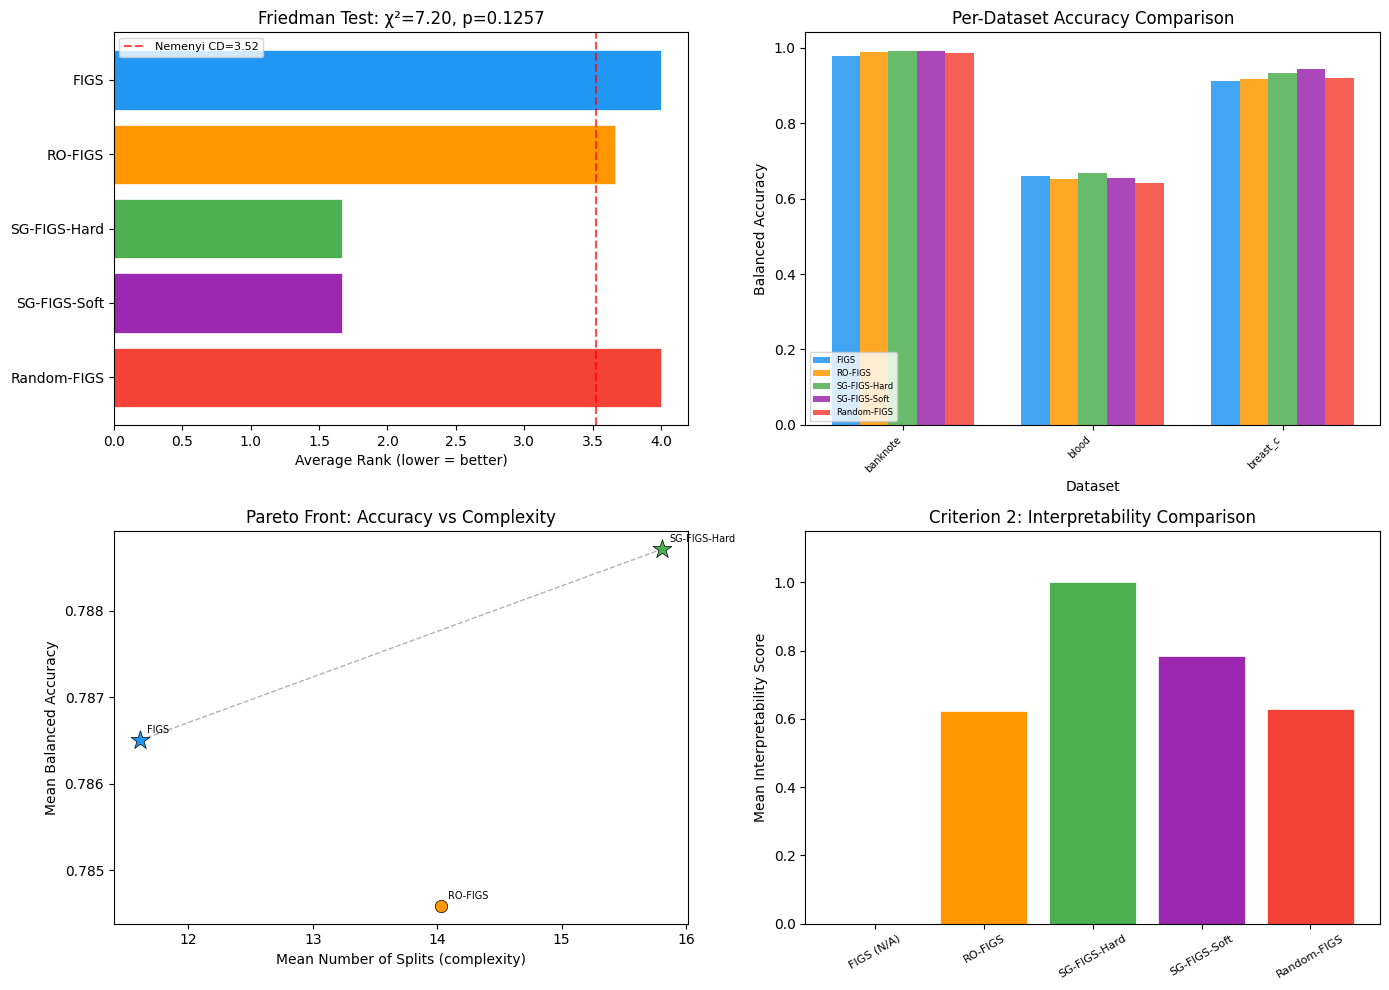

Visualization saved to evaluation_results.png


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ── Plot 1: Average Ranks (lower = better) ─────────────────────────────
ax = axes[0, 0]
labels = [METHOD_LABELS[m] for m in METHODS]
colors = ['#2196F3', '#FF9800', '#4CAF50', '#9C27B0', '#F44336']
bars = ax.barh(labels, avg_ranks_acc, color=colors, edgecolor='white', linewidth=0.5)
ax.axvline(x=cd, color='red', linestyle='--', alpha=0.7, label=f'Nemenyi CD={cd:.2f}')
ax.set_xlabel('Average Rank (lower = better)')
ax.set_title(f'Friedman Test: χ²={chi2_acc:.2f}, p={p_acc:.4f}')
ax.legend(fontsize=8)
ax.invert_yaxis()

# ── Plot 2: Per-Dataset Accuracy Comparison ─────────────────────────────
ax = axes[0, 1]
x = np.arange(n_datasets)
width = 0.15
for j, m in enumerate(METHODS):
    ax.bar(x + j * width, acc_matrix[:, j], width, label=METHOD_LABELS[m], color=colors[j], alpha=0.85)
ax.set_xlabel('Dataset')
ax.set_ylabel('Balanced Accuracy')
ax.set_title('Per-Dataset Accuracy Comparison')
ax.set_xticks(x + width * 2)
ax.set_xticklabels([d[:8] for d in dataset_names], rotation=45, ha='right', fontsize=7)
ax.legend(fontsize=6, loc='lower left')

# ── Plot 3: Pareto Front (Accuracy vs Complexity) ──────────────────────
ax = axes[1, 0]
pareto_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "pareto_analysis")
method_accs, method_splits, method_names_plot, method_pareto = [], [], [], []
for ex in pareto_ds["examples"]:
    output = json.loads(ex["output"])
    method_accs.append(output["mean_accuracy"])
    method_splits.append(output["mean_n_splits"])
    method_names_plot.append(ex["metadata_method"])
    method_pareto.append(output["pareto_optimal"])

for i, (a, s, name, is_pareto) in enumerate(zip(method_accs, method_splits, method_names_plot, method_pareto)):
    marker = '*' if is_pareto else 'o'
    size = 200 if is_pareto else 80
    ax.scatter(s, a, c=colors[i], s=size, marker=marker, edgecolors='black', linewidth=0.5, zorder=5)
    ax.annotate(name, (s, a), textcoords="offset points", xytext=(5, 5), fontsize=7)

# Draw Pareto front line
pareto_points = [(s, a) for s, a, p in zip(method_splits, method_accs, method_pareto) if p]
if pareto_points:
    pareto_points.sort()
    ax.plot([p[0] for p in pareto_points], [p[1] for p in pareto_points], 'k--', alpha=0.3, linewidth=1)

ax.set_xlabel('Mean Number of Splits (complexity)')
ax.set_ylabel('Mean Balanced Accuracy')
ax.set_title('Pareto Front: Accuracy vs Complexity')

# ── Plot 4: Interpretability Comparison ─────────────────────────────────
ax = axes[1, 1]
interp_vals = []
interp_labels = []
for m in METHODS:
    val = interp_avgs.get(m)
    if val is not None:
        interp_vals.append(val)
        interp_labels.append(METHOD_LABELS[m])
    else:
        interp_vals.append(0)
        interp_labels.append(METHOD_LABELS[m] + " (N/A)")

bar_colors = [colors[i] for i in range(len(METHODS))]
ax.bar(interp_labels, interp_vals, color=bar_colors, edgecolor='white', linewidth=0.5)
ax.set_ylabel('Mean Interpretability Score')
ax.set_title('Criterion 2: Interpretability Comparison')
ax.set_ylim(0, 1.15)
ax.tick_params(axis='x', rotation=30, labelsize=8)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Visualization saved to evaluation_results.png")